<a href="https://colab.research.google.com/github/malvarezgarcia1213-png/Project-I-Deep-Learning-Image-Classification-with-CNN/blob/main/Animals_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
#1 CREATE PROJECT FOLDERS
from google.colab import drive
drive.mount('/content/drive')

import os

# Define project root
PROJECT_DIR = '/content/drive/MyDrive/animals_project'

# Define subfolders
SUBFOLDERS = ['models', 'history', 'logs', 'data', 'notebooks', 'app', 'test_images']

# Create folders
os.makedirs(PROJECT_DIR, exist_ok=True)
for sf in SUBFOLDERS:
    os.makedirs(os.path.join(PROJECT_DIR, sf), exist_ok=True)

# Verify structure
print("Project directory:", PROJECT_DIR)
print("Subfolders:", os.listdir(PROJECT_DIR))


MessageError: Error: credential propagation was unsuccessful

In [15]:
#2 IMPORT LIBRARIES

# Core
import os
import random
import numpy as np
import pandas as pd
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Scikit-learn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

# Dataset download
import kagglehub
from google.colab import drive
drive.mount('/content/drive')
print("Libraries imported successfully")


Mounted at /content/drive
Libraries imported successfully


In [16]:
# 3 DATASET DOWNLOAD & VERIFY
import kagglehub, os

path = kagglehub.dataset_download("alessiocorrado99/animals10")
print("Path to dataset files:", path)

DATASET_PATH = os.path.join(path, "raw-img")
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"'raw-img' folder not found inside {path}")

print("Dataset path confirmed:", DATASET_PATH)
classes = sorted(os.listdir(DATASET_PATH))
total_images = sum(len(os.listdir(os.path.join(DATASET_PATH, c))) for c in classes)
print("Classes:", classes)
print("Total images:", total_images)


Using Colab cache for faster access to the 'animals10' dataset.
Path to dataset files: /kaggle/input/animals10
Dataset path confirmed: /kaggle/input/animals10/raw-img
Classes: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Total images: 26179


In [17]:
#5.1 TRANSLATE CLASS NAMES TO ENGLISH



# Map Italian to English
name_map = {
    "cane": "dog",
    "cavallo": "horse",
    "elefante": "elephant",
    "farfalla": "butterfly",
    "gallina": "chicken",
    "gatto": "cat",
    "mucca": "cow",
    "pecora": "sheep",
    "ragno": "spider",
    "scoiattolo": "squirrel"
}

# Original class folders (Italian)
classes_it = sorted([d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))])

# Translated class names (English)
classes_en = [name_map.get(c, c) for c in classes_it]

print("Italian class names:", classes_it)
print("English class names:", classes_en)


Italian class names: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
English class names: ['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']


In [18]:
# #5.3 IMAGE SIZE ANALYSIS (FORMATTED)

widths, heights = [], []

for c_it in classes_it:
    folder = os.path.join(DATASET_PATH, c_it)
    samples = os.listdir(folder)[:100]
    for img_name in samples:
        img_path = os.path.join(folder, img_name)
        try:
            with Image.open(img_path) as img:
                w, h = img.size
                widths.append(w)
                heights.append(h)
        except:
            continue

widths = np.array(widths)
heights = np.array(heights)

print("Overall Statistics:")
print("==================================================")
print(f"Average width:  {widths.mean():.0f} px")
print(f"Average height: {heights.mean():.0f} px")
print(f"Min dimensions: {widths.min():.0f}x{heights.min():.0f} px")
print(f"Max dimensions: {widths.max():.0f}x{heights.max():.0f} px")
print(f"Aspect ratio range: {np.min(widths/heights):.2f} - {np.max(widths/heights):.2f}")


Overall Statistics:
Average width:  350 px
Average height: 266 px
Min dimensions: 160x102 px
Max dimensions: 6016x4000 px
Aspect ratio range: 0.56 - 2.94



5.4.1 Data Visualization - One Sample per Category
--------------------------------------------------


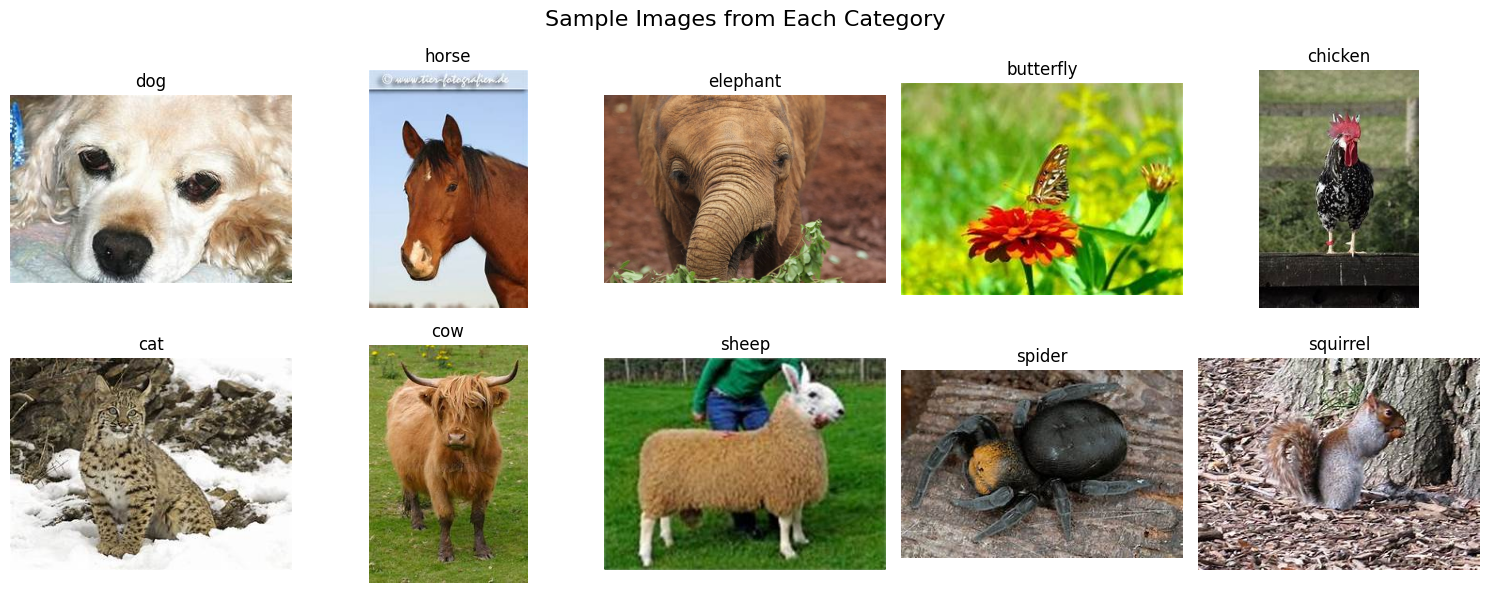

In [19]:
#5.4 VISUALIZE ONE SAMPLE PER CATEGORY

def visualize_sample_images(categories_dict, dataset_path, num_samples=1):
    """
    Display sample images from each category (one per class by default)
    """
    print("\n5.4.1 Data Visualization - One Sample per Category")
    print("-" * 50)

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()

    for i, (italian_name, english_name) in enumerate(categories_dict.items()):
        category_path = os.path.join(dataset_path, italian_name)
        if not os.path.exists(category_path):
            continue

        all_images = os.listdir(category_path)
        if all_images:
            sample_image = random.choice(all_images)
            img_path = os.path.join(category_path, sample_image)

            try:
                img = Image.open(img_path)
                axes[i].imshow(img)
                axes[i].set_title(english_name)
                axes[i].axis('off')
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    plt.suptitle('Sample Images from Each Category', fontsize=16)
    plt.tight_layout()
    plt.show()


# Execute visualization
visualize_sample_images(name_map, DATASET_PATH)



5.4.2 Data Visualization - Multiple Images per Category
--------------------------------------------------


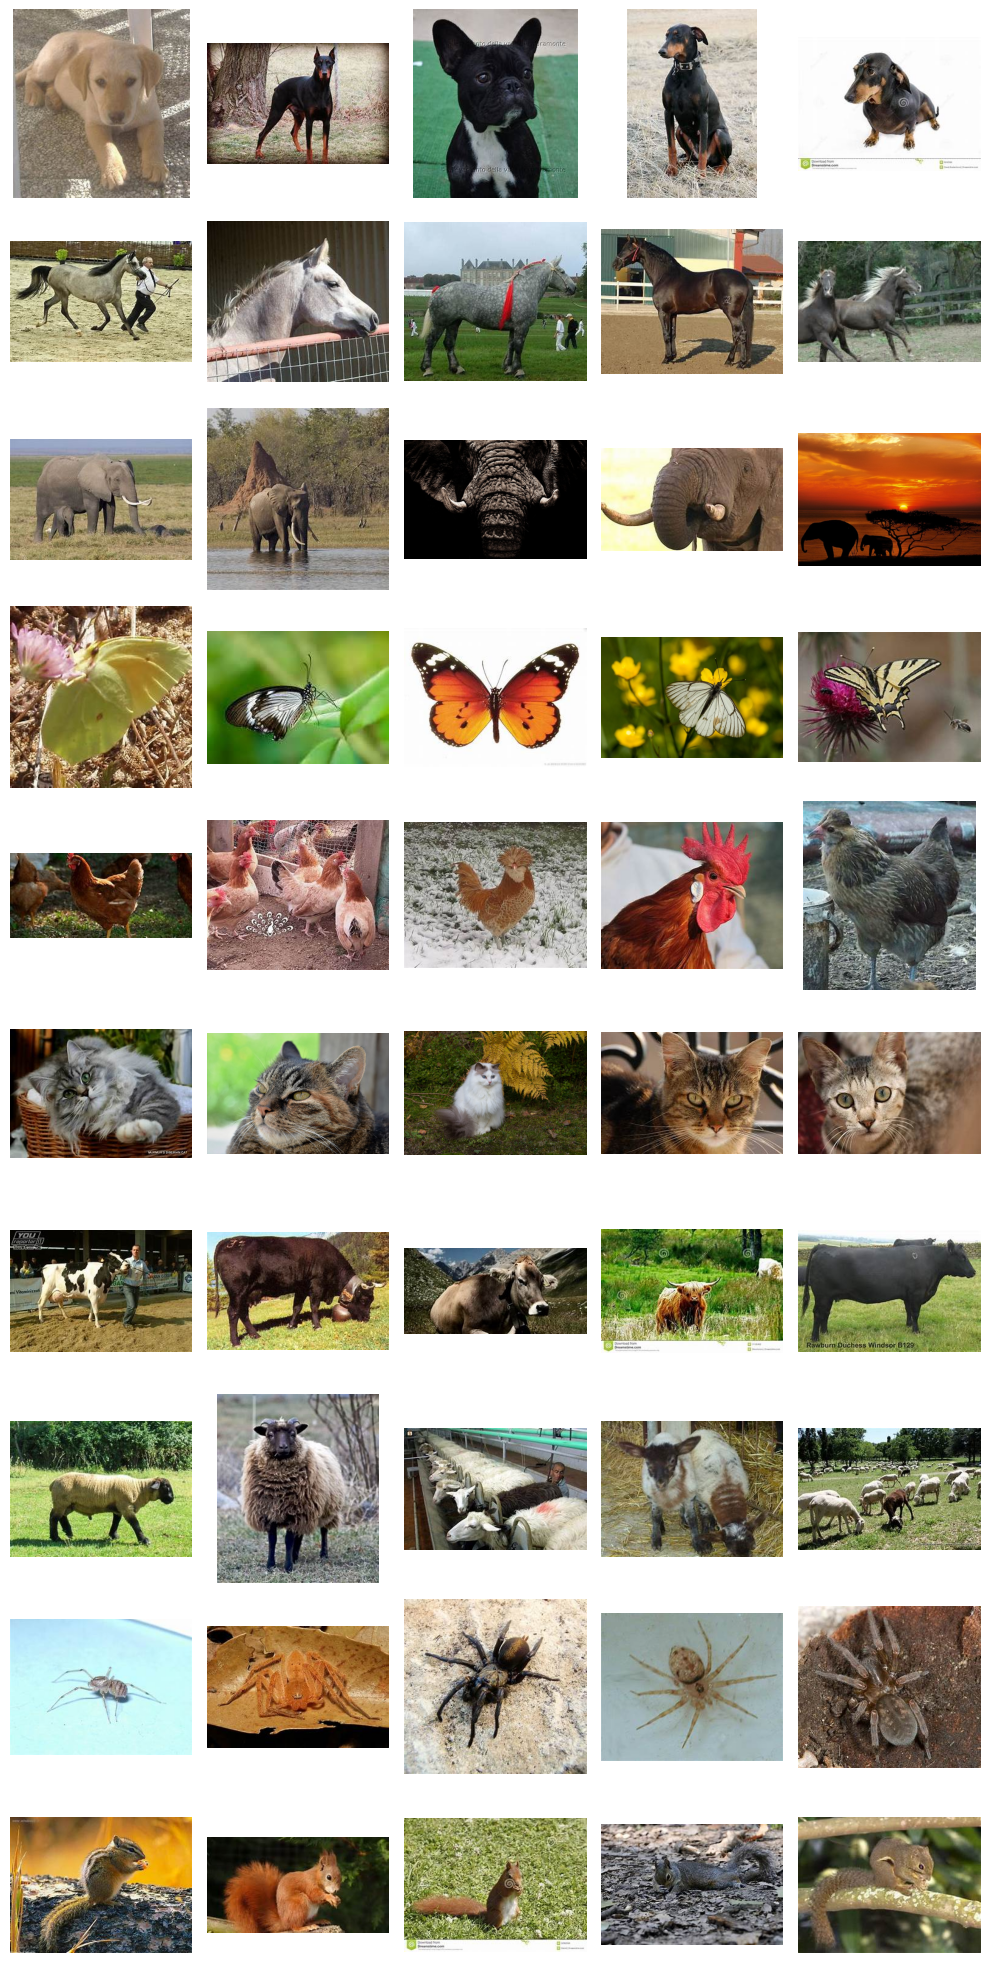

In [21]:
#5.4 VISUALIZE MULTIPLE IMAGES PER CATEGORY

def visualize_multiple_images_per_category(categories_dict, dataset_path, images_per_category=5):
    """
    Display multiple images per category
    """
    print("\n5.4.2 Data Visualization - Multiple Images per Category")
    print("-" * 50)

    fig, axes = plt.subplots(len(categories_dict), images_per_category, figsize=(images_per_category * 2, len(categories_dict) * 2))
    axes = np.array(axes)

    if len(categories_dict) == 1:
        axes = np.expand_dims(axes, 0)

    for i, (italian_name, english_name) in enumerate(categories_dict.items()):
        category_path = os.path.join(dataset_path, italian_name)
        all_images = os.listdir(category_path)
        sample_images = random.sample(all_images, min(images_per_category, len(all_images)))

        for j, img_name in enumerate(sample_images):
            img_path = os.path.join(category_path, img_name)
            try:
                img = Image.open(img_path)
                axes[i, j].imshow(img)
                axes[i, j].axis('off')
                if j == 0:
                    axes[i, j].set_ylabel(english_name, rotation=0, labelpad=40, fontsize=10, va='center')
            except Exception as e:
                axes[i, j].axis('off')
                print(f"Error loading {img_path}: {e}")

    plt.tight_layout()
    plt.show()


# Execute visualization
visualize_multiple_images_per_category(name_map, DATASET_PATH, images_per_category=5)


In [22]:
# #6.1 CONFIGURATION PARAMETERS (OPTIMIZED CONSERVATIVE)

TARGET_SIZE = (224, 224)
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.2
SEED = 42
EPOCHS = 25
LEARNING_RATE = 0.001

MODEL_PATH = '/content/drive/MyDrive/animals_project/models/best_model.h5'

print("CONFIGURATION PARAMETERS:")
print(f"TARGET_SIZE: {TARGET_SIZE}")
print(f"BATCH_SIZE: {BATCH_SIZE}")
print(f"VALIDATION_SPLIT: {VALIDATION_SPLIT}")
print(f"SEED: {SEED}")
print(f"EPOCHS: {EPOCHS}")
print(f"LEARNING_RATE: {LEARNING_RATE}")
print(f"MODEL_PATH: {MODEL_PATH}")


CONFIGURATION PARAMETERS:
TARGET_SIZE: (224, 224)
BATCH_SIZE: 64
VALIDATION_SPLIT: 0.2
SEED: 42
EPOCHS: 25
LEARNING_RATE: 0.001
MODEL_PATH: /content/drive/MyDrive/animals_project/models/best_model.h5


In [23]:
# 6.2 DATA PREPARATION & AUGMENTATION

from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=VALIDATION_SPLIT
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=VALIDATION_SPLIT
)

train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=SEED
)

validation_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=SEED,
    shuffle=False
)

print("EfficientNet preprocessing active. Training samples:", train_generator.samples,
      "Validation samples:", validation_generator.samples)


Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.
EfficientNet preprocessing active. Training samples: 20947 Validation samples: 5232


In [24]:
# #6.3 DATA GENERATORS CREATION

# Training generator
train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=SEED
)

# Validation generator
validation_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=SEED,
    shuffle=False
)

# Display summary
print("\nDATA GENERATORS CREATED:")
print(f"  Training images:   {train_generator.samples}")
print(f"  Validation images: {validation_generator.samples}")
print(f"  Classes detected:  {list(train_generator.class_indices.keys())}")

# Steps per epoch (integer division)
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE

print(f"  Steps per epoch:   {steps_per_epoch}")
print(f"  Validation steps:  {validation_steps}")


Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.

DATA GENERATORS CREATED:
  Training images:   20947
  Validation images: 5232
  Classes detected:  ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
  Steps per epoch:   327
  Validation steps:  81


In [9]:
# Save class order (only run once)
import numpy as np

class_names = list(train_generator.class_indices.keys())
np.save('/content/drive/MyDrive/animals_project/class_names.npy', class_names)
print("Class order saved at: /content/drive/MyDrive/animals_project/class_names.npy")


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/animals_project/class_names.npy'

In [25]:
# #6.4.1 CLASS WEIGHTS CALCULATION

# Compute class weights inversely proportional to class frequency
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(train_generator.class_indices)),
    y=train_generator.classes
)

# Convert to dictionary format required by model.fit()
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Display summary
print("CLASS WEIGHTS CALCULATED:")
print("==================================================")
for i, class_name in enumerate(train_generator.class_indices.keys()):
    print(f"{class_name:15s} | weight = {class_weight_dict[i]:.2f}")


CLASS WEIGHTS CALCULATED:
cane            | weight = 0.54
cavallo         | weight = 1.00
elefante        | weight = 1.81
farfalla        | weight = 1.24
gallina         | weight = 0.84
gatto           | weight = 1.57
mucca           | weight = 1.40
pecora          | weight = 1.44
ragno           | weight = 0.54
scoiattolo      | weight = 1.41


In [26]:
# #6.4.2 CALLBACKS CONFIGURATION

# Stop training if validation loss does not improve after 5 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Reduce learning rate when validation loss stagnates for 3 epochs
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Save the model with the highest validation accuracy
model_checkpoint = ModelCheckpoint(
    MODEL_PATH,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Combine all callbacks in a single list
callbacks = [early_stopping, reduce_lr, model_checkpoint]

print("CALLBACKS CONFIGURED:")
print("==================================================")
print("- EarlyStopping: patience = 5, monitor = val_loss")
print("- ReduceLROnPlateau: factor = 0.2, patience = 3, monitor = val_loss")
print(f"- ModelCheckpoint: saving best model to {MODEL_PATH}")


CALLBACKS CONFIGURED:
- EarlyStopping: patience = 5, monitor = val_loss
- ReduceLROnPlateau: factor = 0.2, patience = 3, monitor = val_loss
- ModelCheckpoint: saving best model to /content/drive/MyDrive/animals_project/models/best_model.h5


In [28]:

# #6.5 MODEL ARCHITECTURE (FUNCTIONAL VERSION)


def create_cnn_model(input_shape=(224, 224, 3), num_classes=10):
    model = Sequential([
        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Block 4
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Classifier
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model
model = create_cnn_model()

optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("MODEL COMPILED SUCCESSFULLY")
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


MODEL COMPILED SUCCESSFULLY


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,683,658 (36.94 MB)

 Trainable params: 9,683,658 (36.94 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# #6.6 TRAINING – BASELINE CNN MODEL

# Train the baseline CNN model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    class_weight=class_weight_dict,
    callbacks=callbacks
)



Epoch 1/25
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 845ms/step - accuracy: 0.2147 - loss: 2.0829

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.41323, saving model to /content/drive/MyDrive/animals_project/models/best_model.h5


328/328 ━━━━━━━━━━━━━━━━━━━━ 298s 898ms/step - accuracy: 0.2149 - loss: 2.0825 - val_accuracy: 0.4132 - val_loss: 1.6116 - learning_rate: 0.0010
Epoch 2/25
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 839ms/step - accuracy: 0.3939 - loss: 1.6907
Epoch 2: val_accuracy improved from 0.41323 to 0.48930, saving model to /content/drive/MyDrive/animals_project/models/best_model.h5


328/328 ━━━━━━━━━━━━━━━━━━━━ 290s 884ms/step - accuracy: 0.3940 - loss: 1.6905 - val_accuracy: 0.4893 - val_loss: 1.4074 - learning_rate: 0.0010
Epoch 3/25
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 852ms/step - accuracy: 0.4682 - loss: 1.5059
Epoch 3: val_accuracy improved from 0.48930 to 0.58677, saving model to /content/drive/MyDrive/animals_project/models/best_model.h5


328/328 ━━━━━━━━━━━━━━━━━━━━ 297s 904ms/step - accuracy: 0.4682 - loss: 1.5058 - val_accuracy: 0.5868 - val_loss: 1.1988 - learning_rate: 0.0010
Epoch 4/25
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 855ms/step - accuracy: 0.5049 - loss: 1.4006
Epoch 4: val_accuracy improved from 0.58677 to 0.60570, saving model to /content/drive/MyDrive/animals_project/models/best_model.h5


328/328 ━━━━━━━━━━━━━━━━━━━━ 295s 900ms/step - accuracy: 0.5049 - loss: 1.4006 - val_accuracy: 0.6057 - val_loss: 1.1310 - learning_rate: 0.0010
Epoch 5/25
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 835ms/step - accuracy: 0.5334 - loss: 1.3228
Epoch 5: val_accuracy improved from 0.60570 to 0.61028, saving model to /content/drive/MyDrive/animals_project/models/best_model.h5


328/328 ━━━━━━━━━━━━━━━━━━━━ 288s 878ms/step - accuracy: 0.5334 - loss: 1.3228 - val_accuracy: 0.6103 - val_loss: 1.1296 - learning_rate: 0.0010
Epoch 6/25
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 831ms/step - accuracy: 0.5692 - loss: 1.2463
Epoch 6: val_accuracy did not improve from 0.61028
328/328 ━━━━━━━━━━━━━━━━━━━━ 284s 864ms/step - accuracy: 0.5692 - loss: 1.2462 - val_accuracy: 0.6078 - val_loss: 1.1466 - learning_rate: 0.0010
Epoch 7/25
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 830ms/step - accuracy: 0.5900 - loss: 1.1642
Epoch 7: val_accuracy improved from 0.61028 to 0.63876, saving model to /content/drive/MyDrive/animals_project/models/best_model.h5


328/328 ━━━━━━━━━━━━━━━━━━━━ 286s 873ms/step - accuracy: 0.5900 - loss: 1.1642 - val_accuracy: 0.6388 - val_loss: 1.0324 - learning_rate: 0.0010
Epoch 8/25
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 819ms/step - accuracy: 0.6205 - loss: 1.0941
Epoch 8: val_accuracy did not improve from 0.63876
328/328 ━━━━━━━━━━━━━━━━━━━━ 278s 848ms/step - accuracy: 0.6204 - loss: 1.0941 - val_accuracy: 0.6294 - val_loss: 1.1160 - learning_rate: 0.0010
Epoch 9/25
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - accuracy: 0.6289 - loss: 1.0591
Epoch 9: val_accuracy did not improve from 0.63876
328/328 ━━━━━━━━━━━━━━━━━━━━ 279s 853ms/step - accuracy: 0.6289 - loss: 1.0591 - val_accuracy: 0.6216 - val_loss: 1.1045 - learning_rate: 0.0010
Epoch 10/25
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 825ms/step - accuracy: 0.6392 - loss: 1.0437
Epoch 10: val_accuracy improved from 0.63876 to 0.68712, saving model to /content/drive/MyDrive/animals_project/models/best_model.h5


328/328 ━━━━━━━━━━━━━━━━━━━━ 282s 861ms/step - accuracy: 0.6392 - loss: 1.0437 - val_accuracy: 0.6871 - val_loss: 0.9127 - learning_rate: 0.0010
Epoch 11/25
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 835ms/step - accuracy: 0.6567 - loss: 0.9957
Epoch 11: val_accuracy did not improve from 0.68712
328/328 ━━━━━━━━━━━━━━━━━━━━ 285s 869ms/step - accuracy: 0.6567 - loss: 0.9957 - val_accuracy: 0.6665 - val_loss: 0.9755 - learning_rate: 0.0010
Epoch 12/25
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 838ms/step - accuracy: 0.6541 - loss: 0.9819
Epoch 12: val_accuracy improved from 0.68712 to 0.72248, saving model to /content/drive/MyDrive/animals_project/models/best_model.h5


328/328 ━━━━━━━━━━━━━━━━━━━━ 288s 879ms/step - accuracy: 0.6541 - loss: 0.9819 - val_accuracy: 0.7225 - val_loss: 0.8113 - learning_rate: 0.0010
Epoch 13/25
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - accuracy: 0.6780 - loss: 0.9473
Epoch 13: val_accuracy did not improve from 0.72248
328/328 ━━━━━━━━━━━━━━━━━━━━ 280s 853ms/step - accuracy: 0.6780 - loss: 0.9473 - val_accuracy: 0.6940 - val_loss: 0.8807 - learning_rate: 0.0010
Epoch 14/25
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 825ms/step - accuracy: 0.6883 - loss: 0.9058
Epoch 14: val_accuracy did not improve from 0.72248
328/328 ━━━━━━━━━━━━━━━━━━━━ 281s 856ms/step - accuracy: 0.6883 - loss: 0.9058 - val_accuracy: 0.6988 - val_loss: 0.8858 - learning_rate: 0.0010
Epoch 15/25
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 821ms/step - accuracy: 0.6971 - loss: 0.8852
Epoch 15: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 15: val_accuracy did not improve from 0.72248
328/328 ━━━━━━━━━━━━━━━━━━━━ 280s 852ms/step - accuracy: 0.6971

328/328 ━━━━━━━━━━━━━━━━━━━━ 284s 866ms/step - accuracy: 0.7256 - loss: 0.8071 - val_accuracy: 0.7525 - val_loss: 0.7535 - learning_rate: 2.0000e-04
Epoch 17/25
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 826ms/step - accuracy: 0.7399 - loss: 0.7740
Epoch 17: val_accuracy did not improve from 0.75248
328/328 ━━━━━━━━━━━━━━━━━━━━ 281s 858ms/step - accuracy: 0.7399 - loss: 0.7739 - val_accuracy: 0.7271 - val_loss: 0.8264 - learning_rate: 2.0000e-04
Epoch 18/25
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 825ms/step - accuracy: 0.7463 - loss: 0.7463
Epoch 18: val_accuracy did not improve from 0.75248
328/328 ━━━━━━━━━━━━━━━━━━━━ 281s 857ms/step - accuracy: 0.7462 - loss: 0.7462 - val_accuracy: 0.6946 - val_loss: 0.9154 - learning_rate: 2.0000e-04
Epoch 19/25
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 835ms/step - accuracy: 0.7511 - loss: 0.7305
Epoch 19: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 19: val_accuracy did not improve from 0.75248
328/328 ━━━━━━━━━━━━━━━━━━━━ 285s 870ms/step - accu

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


82/82 ━━━━━━━━━━━━━━━━━━━━ 60s 475ms/step - accuracy: 0.9767 - loss: 0.0908
VALIDATION RESULTS:
  - Validation Accuracy: 0.9799
  - Validation Loss:     0.0683
82/82 ━━━━━━━━━━━━━━━━━━━━ 22s 195ms/step

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        cane     0.9906    0.9743    0.9824       972
     cavallo     0.9734    0.9790    0.9762       524
    elefante     0.9597    0.9896    0.9744       289
    farfalla     0.9858    0.9882    0.9870       422
     gallina     0.9935    0.9952    0.9944       619
       gatto     0.9585    0.9700    0.9642       333
       mucca     0.9496    0.9598    0.9547       373
      pecora     0.9586    0.9533    0.9559       364
       ragno     0.9927    0.9938    0.9933       964
  scoiattolo     0.9864    0.9731    0.9797       372

    accuracy                         0.9799      5232
   macro avg     0.9749    0.9776    0.9762      5232
weighted avg     0.9800    0.9799    0.9799      5232



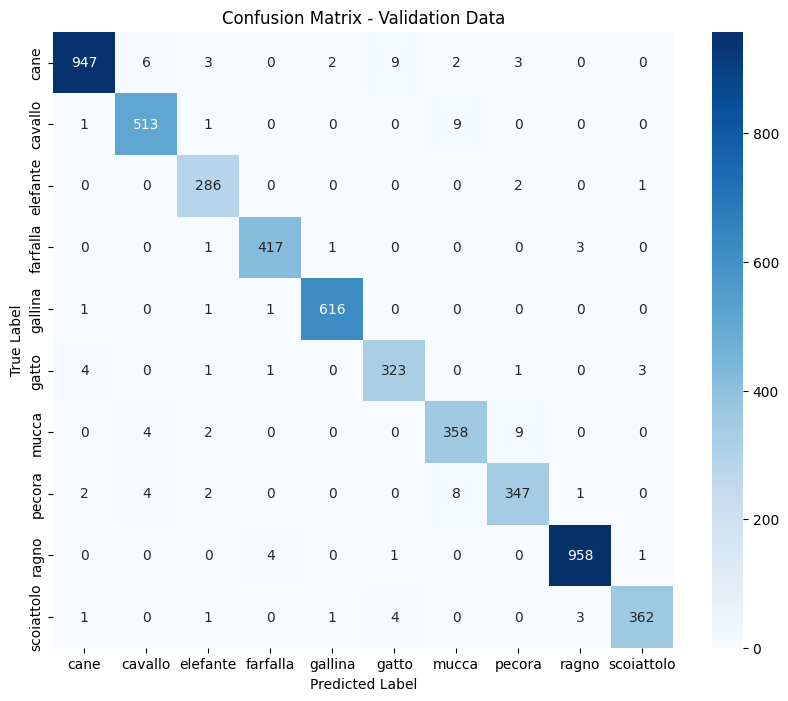

In [31]:
# ==========================================================
# #6.7 MODEL EVALUATION & CLASSIFICATION REPORT
# ==========================================================

# Load best model (saved automatically by ModelCheckpoint)
MODEL_PATH = '/content/drive/MyDrive/Project animals/Copia de best_model.h5'
best_model = load_model(MODEL_PATH)

# Evaluate model on validation data
val_loss, val_acc = best_model.evaluate(validation_generator, verbose=1)
print("==================================================")
print(f"VALIDATION RESULTS:")
print(f"  - Validation Accuracy: {val_acc:.4f}")
print(f"  - Validation Loss:     {val_loss:.4f}")
print("==================================================")

# Predictions
validation_generator.reset()
preds = best_model.predict(validation_generator, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = validation_generator.classes

# Classification report
print("\nCLASSIFICATION REPORT:")
print("==================================================")
print(classification_report(
    y_true,
    y_pred,
    target_names=list(validation_generator.class_indices.keys()),
    digits=4
))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=validation_generator.class_indices.keys(),
    yticklabels=validation_generator.class_indices.keys()
)
plt.title("Confusion Matrix - Validation Data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [32]:
# ==========================================================
# #6.8 TRAINING HISTORY & FINAL METRICS
# ==========================================================

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot curves
plot_training_history(history)

# Final metrics summary
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print("==================================================")
print("FINAL TRAINING METRICS SUMMARY")
print("==================================================")
print(f"Final training accuracy:   {final_train_acc:.4f}")
print(f"Final validation accuracy: {final_val_acc:.4f}")
print(f"Final training loss:       {final_train_loss:.4f}")
print(f"Final validation loss:     {final_val_loss:.4f}")
print("==================================================")


NameError: name 'history' is not defined

In [33]:
# ==========================================================
# #7.1 LOAD PRE-TRAINED EFFICIENTNETB0 (FROZEN BASE)
# ==========================================================

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

# Load EfficientNetB0 without the top classifier
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3)
)

# Freeze all layers for feature extraction phase
for layer in base_model.layers:
    layer.trainable = False

# Build the new classification head
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(len(train_generator.class_indices), activation='softmax')(x)

# Combine base + head
model_tl = keras.Model(inputs=base_model.input, outputs=output)

# Compile the model (feature extraction stage)
model_tl.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# ==========================================================
# #7.1 TRAINING — FEATURE EXTRACTION STAGE
# ==========================================================

# Entrenamos únicamente la cabeza del modelo (base congelada)
history_tl_stage1 = model_tl.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=1
)

# Evaluación inicial
val_loss_1, val_acc_1 = model_tl.evaluate(validation_generator, verbose=1)

print("\n==================================================")
print("INITIAL TRANSFER LEARNING RESULTS (STAGE 1)")
print("--------------------------------------------------")
print(f"Validation Accuracy: {val_acc_1:.4f}")
print(f"Validation Loss:     {val_loss_1:.4f}")
print("==================================================")


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 826ms/step - accuracy: 0.8253 - loss: 0.5958
Epoch 1: val_accuracy improved from 0.75248 to 0.97357, saving model to /content/drive/MyDrive/animals_project/models/best_model.h5


327/327 ━━━━━━━━━━━━━━━━━━━━ 282s 862ms/step - accuracy: 0.8255 - loss: 0.5949 - val_accuracy: 0.9736 - val_loss: 0.1018 - learning_rate: 2.0000e-04
Epoch 2/25
  1/327 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.9219 - loss: 0.2491
Epoch 2: val_accuracy did not improve from 0.97357
327/327 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.9219 - loss: 0.2491 - val_accuracy: 0.9736 - val_loss: 0.1020 - learning_rate: 2.0000e-04
Epoch 3/25
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 830ms/step - accuracy: 0.9511 - loss: 0.1757
Epoch 3: val_accuracy improved from 0.97357 to 0.97608, saving model to /content/drive/MyDrive/animals_project/models/best_model.h5


327/327 ━━━━━━━━━━━━━━━━━━━━ 283s 867ms/step - accuracy: 0.9511 - loss: 0.1757 - val_accuracy: 0.9761 - val_loss: 0.0904 - learning_rate: 2.0000e-04
Epoch 4/25
  1/327 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.9688 - loss: 0.0741
Epoch 4: val_accuracy did not improve from 0.97608
327/327 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9688 - loss: 0.0741 - val_accuracy: 0.9761 - val_loss: 0.0907 - learning_rate: 2.0000e-04
Epoch 5/25
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - accuracy: 0.9563 - loss: 0.1509
Epoch 5: val_accuracy improved from 0.97608 to 0.97762, saving model to /content/drive/MyDrive/animals_project/models/best_model.h5


327/327 ━━━━━━━━━━━━━━━━━━━━ 281s 859ms/step - accuracy: 0.9563 - loss: 0.1509 - val_accuracy: 0.9776 - val_loss: 0.0820 - learning_rate: 2.0000e-04
Epoch 6/25
  1/327 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.9531 - loss: 0.1272
Epoch 6: val_accuracy did not improve from 0.97762
327/327 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.9531 - loss: 0.1272 - val_accuracy: 0.9772 - val_loss: 0.0820 - learning_rate: 2.0000e-04
Epoch 7/25
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 829ms/step - accuracy: 0.9545 - loss: 0.1540
Epoch 7: val_accuracy improved from 0.97762 to 0.97840, saving model to /content/drive/MyDrive/animals_project/models/best_model.h5


327/327 ━━━━━━━━━━━━━━━━━━━━ 284s 869ms/step - accuracy: 0.9545 - loss: 0.1540 - val_accuracy: 0.9784 - val_loss: 0.0793 - learning_rate: 2.0000e-04
Epoch 8/25
  1/327 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.9219 - loss: 0.2457
Epoch 8: val_accuracy did not improve from 0.97840
327/327 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.9219 - loss: 0.2457 - val_accuracy: 0.9780 - val_loss: 0.0791 - learning_rate: 2.0000e-04
Epoch 9/25
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 818ms/step - accuracy: 0.9620 - loss: 0.1257
Epoch 9: val_accuracy did not improve from 0.97840
327/327 ━━━━━━━━━━━━━━━━━━━━ 278s 850ms/step - accuracy: 0.9620 - loss: 0.1257 - val_accuracy: 0.9776 - val_loss: 0.0788 - learning_rate: 2.0000e-04
Epoch 10/25
  1/327 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9531 - loss: 0.1142
Epoch 10: val_accuracy did not improve from 0.97840
327/327 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.9531 - loss: 0.1142 - val_accuracy: 0.9778 - val_loss: 0.0788 - learning_rate: 

327/327 ━━━━━━━━━━━━━━━━━━━━ 286s 873ms/step - accuracy: 0.9643 - loss: 0.1209 - val_accuracy: 0.9786 - val_loss: 0.0737 - learning_rate: 2.0000e-04
Epoch 14/25
  1/327 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.9375 - loss: 0.2240
Epoch 14: val_accuracy did not improve from 0.97859
327/327 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.9375 - loss: 0.2240 - val_accuracy: 0.9784 - val_loss: 0.0737 - learning_rate: 2.0000e-04
Epoch 15/25
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - accuracy: 0.9652 - loss: 0.1166
Epoch 15: val_accuracy improved from 0.97859 to 0.97936, saving model to /content/drive/MyDrive/animals_project/models/best_model.h5


327/327 ━━━━━━━━━━━━━━━━━━━━ 283s 865ms/step - accuracy: 0.9651 - loss: 0.1166 - val_accuracy: 0.9794 - val_loss: 0.0705 - learning_rate: 2.0000e-04
Epoch 16/25
  1/327 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9688 - loss: 0.0738
Epoch 16: val_accuracy did not improve from 0.97936
327/327 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.9688 - loss: 0.0738 - val_accuracy: 0.9794 - val_loss: 0.0704 - learning_rate: 2.0000e-04
Epoch 17/25
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - accuracy: 0.9652 - loss: 0.1167
Epoch 17: val_accuracy improved from 0.97936 to 0.98013, saving model to /content/drive/MyDrive/animals_project/models/best_model.h5


327/327 ━━━━━━━━━━━━━━━━━━━━ 281s 859ms/step - accuracy: 0.9652 - loss: 0.1167 - val_accuracy: 0.9801 - val_loss: 0.0679 - learning_rate: 2.0000e-04
Epoch 18/25
  1/327 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9688 - loss: 0.0952
Epoch 18: val_accuracy did not improve from 0.98013
327/327 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.9688 - loss: 0.0952 - val_accuracy: 0.9801 - val_loss: 0.0679 - learning_rate: 2.0000e-04
Epoch 19/25
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - accuracy: 0.9659 - loss: 0.1122
Epoch 19: val_accuracy did not improve from 0.98013
327/327 ━━━━━━━━━━━━━━━━━━━━ 275s 841ms/step - accuracy: 0.9659 - loss: 0.1122 - val_accuracy: 0.9796 - val_loss: 0.0699 - learning_rate: 2.0000e-04
Epoch 20/25
  1/327 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.9688 - loss: 0.0935
Epoch 20: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 20: val_accuracy did not improve from 0.98013
327/327 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 

In [ ]:
# 7.2 SAVE CURRENT MODEL (FEATURE EXTRACTION STAGE)

# Ruta para guardar el modelo actual (antes de fine-tuning)
MODEL_PATH_STAGE1 = '/content/drive/MyDrive/animals_project/models/efficientnet_stage1.h5'

# Guardar modelo completo (arquitectura + pesos + optimizador)
model_tl.save(MODEL_PATH_STAGE1)

print("Model saved successfully at:", MODEL_PATH_STAGE1)


Model saved successfully at: /content/drive/MyDrive/animals_project/models/efficientnet_stage1.h5


In [62]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
from tensorflow.keras.models import load_model

MODEL_PATH_STAGE1 = '/content/drive/MyDrive/Project animals/Copia de efficientnet_stage1.h5'
model_tl = load_model(MODEL_PATH_STAGE1)
print("Model loaded successfully from:", MODEL_PATH_STAGE1)


Model loaded successfully from: /content/drive/MyDrive/Project animals/Copia de efficientnet_stage1.h5


In [36]:
# 7.3 PREPARATION FOR FINE-TUNING

from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Load the previously saved feature extraction model
FINE_TUNE_PATH = '/content/drive/MyDrive/Project animals/Copia de efficientnet_stage1.h5'
model_tl = load_model(FINE_TUNE_PATH)
print("Model successfully loaded from:", FINE_TUNE_PATH)

# Unfreeze top layers for fine-tuning (keep early layers frozen)
FINE_TUNE_AT = 100  # For GPU L4, this is a safe unfreeze depth
for layer in model_tl.layers[:FINE_TUNE_AT]:
    layer.trainable = False
for layer in model_tl.layers[FINE_TUNE_AT:]:
    layer.trainable = True

# Recompile the model with a smaller learning rate for fine-tuning
model_tl.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Model prepared for fine-tuning. Unfrozen from layer {FINE_TUNE_AT} onward.")


Model successfully loaded from: /content/drive/MyDrive/Project animals/Copia de efficientnet_stage1.h5
Model prepared for fine-tuning. Unfrozen from layer 100 onward.


In [37]:
# 7.4 FINE-TUNING TRAINING

# Define fine-tuning epochs
FINE_TUNE_EPOCHS = 10

# Train the model using the existing generators and class weights
history_finetune = model_tl.fit(
    train_generator,
    epochs=FINE_TUNE_EPOCHS,
    validation_data=validation_generator,
    class_weight=class_weight_dict,
    verbose=1
)

# 7.4 SAVE FINE-TUNED MODEL (ARCHITECTURE + WEIGHTS SEPARATELY)

# Define save paths
MODEL_ARCH_PATH = '/content/drive/MyDrive/animals_project/models/efficientnet_finetuned_v3_architecture.json'
MODEL_WEIGHTS_PATH = '/content/drive/MyDrive/animals_project/models/efficientnet_finetuned_v3_weights.h5'

# Save architecture as JSON
with open(MODEL_ARCH_PATH, 'w') as json_file:
    json_file.write(model_tl.to_json())

# Save model weights separately
model_tl.save_weights(MODEL_WEIGHTS_PATH)

print("Fine-tuned model saved successfully:")
print(f"  Architecture: {MODEL_ARCH_PATH}")
print(f"  Weights:      {MODEL_WEIGHTS_PATH}")


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
 20/328 ━━━━━━━━━━━━━━━━━━━━ 4:52 951ms/step - accuracy: 0.8757 - loss: 0.3745

KeyboardInterrupt: 

In [67]:
# 7.4 SAVE FINE-TUNED MODEL (KERAS 3 COMPATIBLE)

# Save full fine-tuned model
FINE_TUNED_MODEL_PATH = '/content/drive/MyDrive/Project animals/Copia de efficientnet_finetuned_v3.keras'
model_tl.save(FINE_TUNED_MODEL_PATH)
print(f"Full fine-tuned model saved at: {FINE_TUNED_MODEL_PATH}")

# Also save weights separately (optional)
MODEL_WEIGHTS_PATH = '/content/drive/MyDrive/animals_project/models/efficientnet_finetuned_v3.weights.h5'
model_tl.save_weights(MODEL_WEIGHTS_PATH)
print(f"Fine-tuned model weights saved at: {MODEL_WEIGHTS_PATH}")

# Quick verification
print("\nFiles saved:")
!ls -lh /content/drive/MyDrive/animals_project/models/


Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7bd92c721620>
Traceback (most recent call last):
  File "/usr/lib/python3.12/weakref.py", line 369, in remove
    def remove(k, selfref=ref(self)):

KeyboardInterrupt: 


Full fine-tuned model saved at: /content/drive/MyDrive/Project animals/Copia de efficientnet_finetuned_v3.keras


FileNotFoundError: [Errno 2] Unable to synchronously create file (unable to open file: name = '/content/drive/MyDrive/animals_project/models/efficientnet_finetuned_v3.weights.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

Fine-tuned model loaded from: /content/drive/MyDrive/Project animals/Copia de efficientnet_finetuned_v3.keras
82/82 ━━━━━━━━━━━━━━━━━━━━ 23s 176ms/step - accuracy: 0.9777 - loss: 0.0938

VALIDATION RESULTS:
  - Validation Accuracy: 0.9801
  - Validation Loss:     0.0705


82/82 ━━━━━━━━━━━━━━━━━━━━ 22s 193ms/step

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        cane       0.99      0.98      0.98       972
     cavallo       0.98      0.97      0.98       524
    elefante       0.96      0.99      0.98       289
    farfalla       0.99      0.99      0.99       422
     gallina       0.99      0.99      0.99       619
       gatto       0.97      0.97      0.97       333
       mucca       0.94      0.97      0.95       373
      pecora       0.96      0.95      0.95       364
       ragno       1.00      0.99      0.99       964
  scoiattolo       0.98      0.98      0.98       372

    accuracy                           0.98      5232
   macro avg       0.98      0.98      0.98      5232
weighted avg       0.98      0.98      0.98      5232



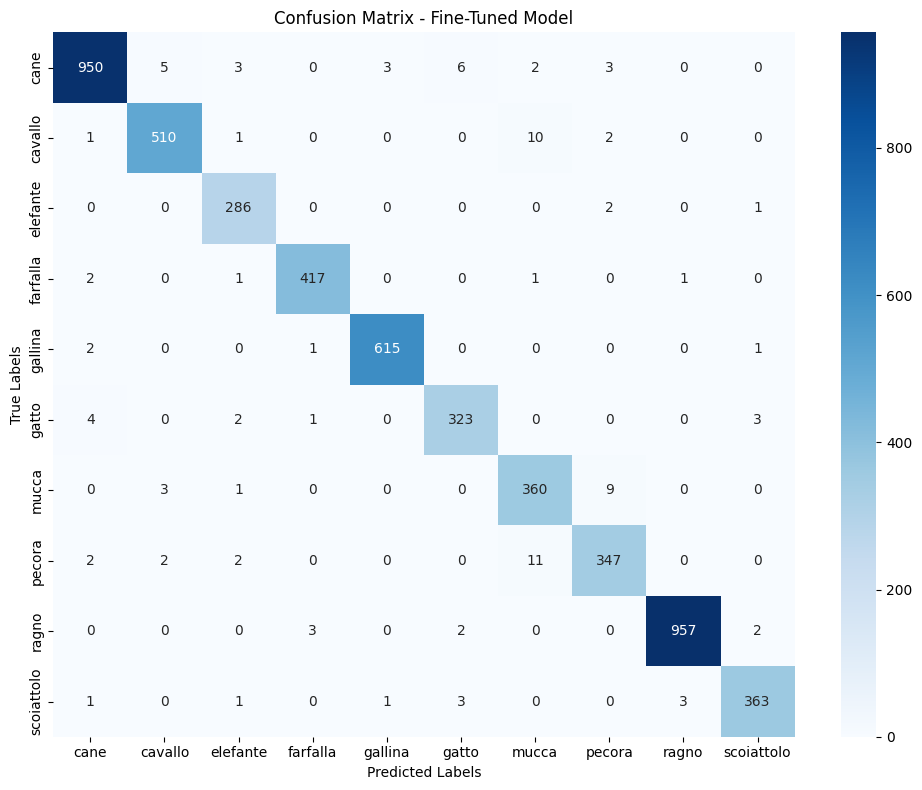

In [68]:
# 7.5 EVALUATION & CLASSIFICATION REPORT (FINE-TUNED MODEL)

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the fine-tuned model
FINE_TUNED_MODEL_PATH = '/content/drive/MyDrive/Project animals/Copia de efficientnet_finetuned_v3.keras'
model_finetuned = tf.keras.models.load_model(FINE_TUNED_MODEL_PATH)
print(f"Fine-tuned model loaded from: {FINE_TUNED_MODEL_PATH}")

# Evaluate model on validation data
val_loss, val_accuracy = model_finetuned.evaluate(validation_generator)
print("\nVALIDATION RESULTS:")
print(f"  - Validation Accuracy: {val_accuracy:.4f}")
print(f"  - Validation Loss:     {val_loss:.4f}")

# Predict on validation set
Y_pred = model_finetuned.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Generate classification report
print("\nCLASSIFICATION REPORT:")
print("==================================================")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - Fine-Tuned Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()


COMPARISON TABLE:
                    Model  Accuracy   Loss  Macro F1-score
             Baseline CNN    0.7525 0.7535           0.734
  EfficientNet (Transfer)    0.9799 0.0683           0.970
EfficientNet (Fine-Tuned)    0.9784 0.0722           0.970


/tmp/ipython-input-2159897253.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=df_results, palette='viridis', ax=axes[0])
/tmp/ipython-input-2159897253.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Loss', data=df_results, palette='magma', ax=axes[1])


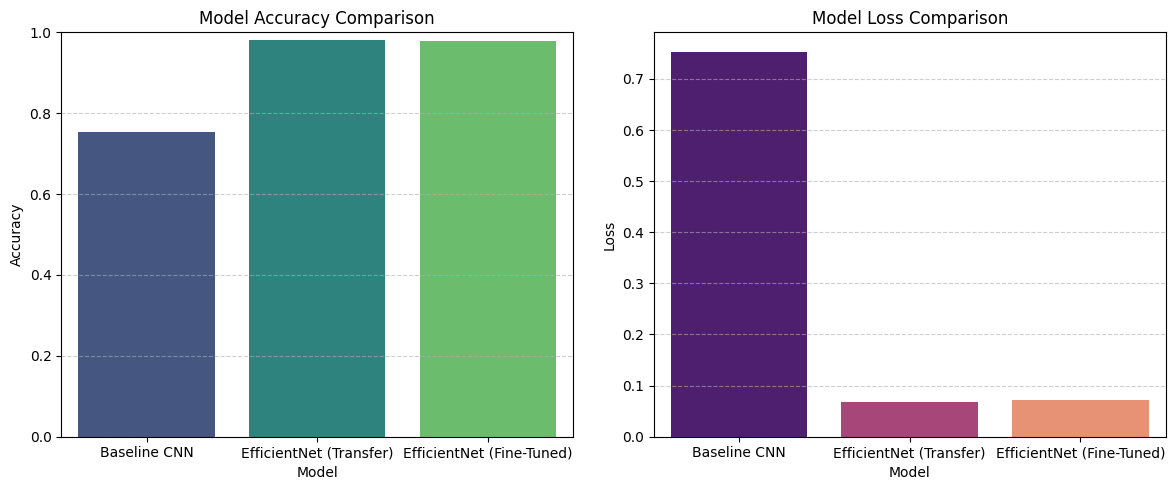


RELATIVE IMPROVEMENT:
  Transfer Learning improved over Baseline CNN by: 22.74%
  Fine-Tuning improved over Baseline CNN by: 22.59%


In [38]:
# 8. MODEL COMPARISON – BASELINE VS TRANSFER VS FINE-TUNED

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# =========================
# 1. Define evaluation results manually
# =========================

results = {
    'Model': ['Baseline CNN', 'EfficientNet (Transfer)', 'EfficientNet (Fine-Tuned)'],
    'Accuracy': [0.7525, 0.9799, 0.9784],
    'Loss': [0.7535, 0.0683, 0.0722],
    'Macro F1-score': [0.7340, 0.97, 0.97]
}

df_results = pd.DataFrame(results)
print("COMPARISON TABLE:")
print(df_results.to_string(index=False))

# =========================
# 2. Plot Accuracy & Loss comparison
# =========================

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy
sns.barplot(x='Model', y='Accuracy', data=df_results, palette='viridis', ax=axes[0])
axes[0].set_title('Model Accuracy Comparison')
axes[0].set_ylim(0, 1)
axes[0].grid(axis='y', linestyle='--', alpha=0.6)

# Loss
sns.barplot(x='Model', y='Loss', data=df_results, palette='magma', ax=axes[1])
axes[1].set_title('Model Loss Comparison')
axes[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# =========================
# 3. Optional: Relative improvement summary
# =========================

improvement_transfer = (df_results.loc[1, 'Accuracy'] - df_results.loc[0, 'Accuracy']) * 100
improvement_finetuned = (df_results.loc[2, 'Accuracy'] - df_results.loc[0, 'Accuracy']) * 100

print("\nRELATIVE IMPROVEMENT:")
print(f"  Transfer Learning improved over Baseline CNN by: {improvement_transfer:.2f}%")
print(f"  Fine-Tuning improved over Baseline CNN by: {improvement_finetuned:.2f}%")


In [57]:
# Load the saved class order
class_names = np.load('/content/drive/MyDrive/Project animals/Copia de class_names.npy', allow_pickle=True)

# Get top 3 predictions
top_indices = preds.argsort()[-3:][::-1]
top_classes = [class_names[i] for i in top_indices]
top_confidences = [preds[i] * 100 for i in top_indices]


Saving puppy-3979350_1280.jpg to puppy-3979350_1280.jpg

File uploaded: puppy-3979350_1280.jpg
Preprocessed image shape: (1, 224, 224, 3)
Pixel range before feeding to model: 0.0 - 255.0

Top 3 predicted classes:
cane            (99.53%)
elefante        (0.23%)
pecora          (0.08%)


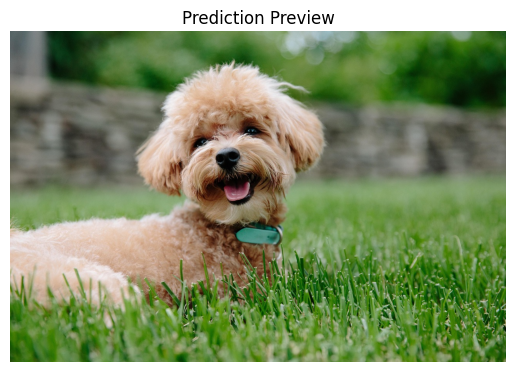

In [64]:
# =====================================================
# IMAGE PREDICTION BLOCK – CLEAN AND REUSABLE VERSION
# =====================================================

import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from google.colab import files

# 1️⃣ Upload an image
uploaded = files.upload()

for filename in uploaded.keys():
    img_path = filename
    print(f"\nFile uploaded: {img_path}")

    # 2️⃣ Load the image (NO manual normalization!)
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    print("Preprocessed image shape:", img_array.shape)
    print("Pixel range before feeding to model:", img_array.min(), "-", img_array.max())

    # 3️⃣ Make prediction
    preds = model.predict(img_array, verbose=0)[0]

    # 4️⃣ Load class names
    class_names = np.load('/content/drive/MyDrive/Project animals/Copia de class_names.npy')

    # 5️⃣ Get top-3 predictions
    top_indices = preds.argsort()[-3:][::-1]
    print("\nTop 3 predicted classes:")
    for i in top_indices:
        print(f"{class_names[i]:15s} ({preds[i]*100:.2f}%)")

    # 6️⃣ Display the image
    plt.imshow(image.load_img(img_path))
    plt.axis('off')
    plt.title("Prediction Preview")
    plt.show()


In [49]:
!pip install gradio


In [73]:
import gradio as gr
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from PIL import Image

# --- Cargar modelo ---
model = tf.keras.models.load_model('/content/drive/MyDrive/Project animals/Copia de efficientnet_finetuned_v3.keras')

# --- Clases ---
class_names = ['dog', 'cat', 'horse', 'elephant', 'butterfly',
               'chicken', 'cow', 'sheep', 'spider', 'squirrel']

In [81]:
def predict(img):

    # Hacer la predicción
    preds = model.predict(img_array)
    pred_index = np.argmax(preds)
    confidence = np.max(preds)

    # Devolver el resultado
    return {class_names[i]: float(preds[0][i]) for i in range(len(class_names))}

In [82]:
interface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil", label="Sube una imagen"),
    outputs=gr.Label(num_top_classes=3, label="Predicciones"),
    title="🐾 Clasificador de Animales",
    description="Sube una imagen y el modelo te dirá qué animal es.",
    examples=[
        ["perro.jpg"],
        ["gato.jpg"]
    ]  # opcional
)


In [83]:
interface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://212354f63fbb1ca01a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [85]:
save_dir = '/content/drive/MyDrive/Project animals'


In [87]:
model.save(f"{save_dir}/fine_tuned_model.keras")
